In [6]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import stats
%matplotlib inline
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.decomposition import PCA
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.manifold import TSNE


#scaling
from sklearn.preprocessing import StandardScaler

#Preprocessing
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection


In [7]:
df = pd.read_csv("data/data.csv", header=0)
df = df.rename(columns={"Unnamed: 0": "Patient ID"})


In [8]:
df.head()

,Patient ID,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20532 entries, Patient ID to gene_20530
dtypes: float64(20531), object(1)
memory usage: 125.5+ MB


In [10]:
df.shape , df.size

((801, 20532), 16446132)

In [11]:
df_label = pd.read_csv("./data/labels.csv", header=0)
df_label = df_label.rename(columns={"Unnamed: 0": "Patient ID"})
df_label.head()

,Patient ID,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA


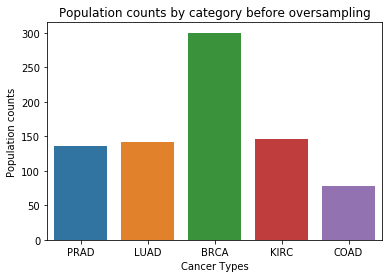

In [12]:
sns.countplot(df_label['Class']).set_title("Population counts by category before oversampling")
plt.xlabel("Cancer Types")
plt.ylabel("Population counts")
plt.show()

In [13]:
df.describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.0,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,3.010909,3.095350,6.722305,9.813612,0.0,7.405509,0.499882,0.016744,0.013428,...,5.896573,8.765891,10.056252,4.847727,9.741987,11.742228,10.155271,9.590726,5.528177,0.095411
std,0.136850,1.200828,1.065601,0.638819,0.506537,0.0,1.108237,0.508799,0.133635,0.204722,...,0.746399,0.603176,0.379278,2.382728,0.533898,0.670371,0.580569,0.563849,2.073859,0.364529
min,0.000000,0.000000,0.000000,5.009284,8.435999,0.0,3.930747,0.000000,0.000000,0.000000,...,2.853517,6.678368,8.669456,0.000000,7.974942,9.045255,7.530141,7.864533,0.593975,0.000000
25%,0.000000,2.299039,2.390365,6.303346,9.464466,0.0,6.676042,0.000000,0.000000,0.000000,...,5.454926,8.383834,9.826027,3.130750,9.400747,11.315857,9.836525,9.244219,4.092385,0.000000
50%,0.000000,3.143687,3.127006,6.655893,9.791599,0.0,7.450114,0.443076,0.000000,0.000000,...,5.972582,8.784144,10.066385,5.444935,9.784524,11.749802,10.191207,9.566511,5.218618,0.000000
75%,0.000000,3.883484,3.802534,7.038447,10.142324,0.0,8.121984,0.789354,0.000000,0.000000,...,6.411292,9.147136,10.299025,6.637412,10.082269,12.177852,10.578561,9.917888,6.876382,0.000000
max,1.482332,6.237034,6.063484,10.129528,11.355621,0.0,10.718190,2.779008,1.785592,4.067604,...,7.771054,11.105431,11.318243,9.207495,11.811632,13.715361,11.675653,12.813320,11.205836,5.254133


In [14]:
df_label.describe()

,Patient ID,Class
count,801,801
unique,801,5
top,sample_550,BRCA
freq,1,300


In [15]:
print('Number of training patients: {}'.format(len(df)))

Number of training patients: 801


In [16]:
print('Percantage of Each Tumor: \n{}'.format(df_label['Class'].value_counts(normalize = True)*100))

Percantage of Each Tumor: 
BRCA    37.453184
KIRC    18.227216
LUAD    17.602996
PRAD    16.978777
COAD     9.737828
Name: Class, dtype: float64


In [17]:
df.isnull().sum().sum()


0

In [18]:
df = df.assign(Class = pd.Series(df_label['Class'].values))

In [19]:
a = df.shape
a = a[0] * a[1]
b = (df != 0).sum(1).sum()
sparsity = 1 - (b/a)
sparsity*100

14.216170273205343

In [20]:
labelenc = preprocessing.LabelEncoder()
labelenc.fit(df['Class'].unique())
labelenc.classes_



array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype=object)

In [21]:
labelenc.inverse_transform([0, 1, 2, 3, 4])
df['Class'] = labelenc.transform(df['Class'])

In [22]:
s = df['Class'].unique()
s.sort()
s

array([0, 1, 2, 3, 4])

In [23]:
df.iloc[:, 1:-1].head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [24]:
X = np.array(df.iloc[:, 1:-1].values)
y = np.array(df.iloc[:, -1].values) 

In [25]:
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [26]:
print('Original dataset shape %s' % Counter(y_train))

Original dataset shape Counter({0: 210, 2: 108, 4: 95, 3: 94, 1: 53})


## Oversampling using Synthetic Minority Over-sampling Technique (SMOTE)

In [27]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy ='auto', k_neighbors=5, random_state = 1)
              
X_res, y_res = smote.fit_resample(X_train, y_train)
              
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 210, 4: 210, 3: 210, 2: 210, 1: 210})


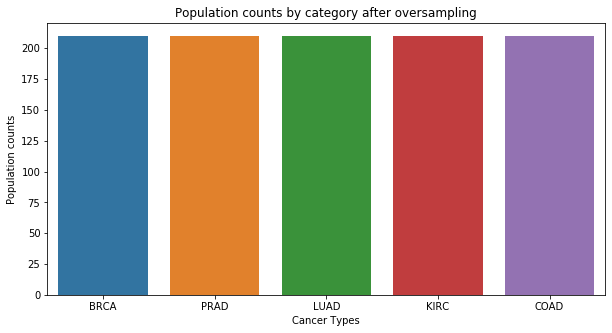

In [28]:
plt.figure(figsize=(10, 5))
sns.countplot(labelenc.inverse_transform(y_res)).set_title("Population counts by category after oversampling")
plt.xlabel("Cancer Types")
plt.ylabel("Population counts")
plt.show()

In [29]:
stdsc = StandardScaler()

X_train = stdsc.fit_transform(X_res)
X_test = stdsc.transform(X_test)
y_train = y_res

## Calculating feature importances using Random Forest Classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=1500, n_jobs=3)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1500,
                       n_jobs=3, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [31]:
print("Training accuracy:", rnd_clf.score(X_train, y_train)*100)
print("Test accuracy:", rnd_clf.score(X_test, y_test)*100)

Training accuracy: 100.0
Test accuracy: 99.1701244813278


In [32]:
list_features = sorted(zip(rnd_clf.feature_importances_, df.columns), reverse=True, key = lambda x: x[0])
top_features = {}
for row in list_features[:20]:
    top_features[row[1]] = row[0]
print("Top 20 features list and their importances:")
list_features[:20]

Top 20 features list and their importances:


[(0.005468900038719805, 'gene_15895'),
 (0.005250733746370524, 'gene_202'),
 (0.004940640061056772, 'gene_7963'),
 (0.004653810951913469, 'gene_15897'),
 (0.004502168551154065, 'gene_15898'),
 (0.004480180481692647, 'gene_18745'),
 (0.004269880808977454, 'gene_15894'),
 (0.004235235346404828, 'gene_11549'),
 (0.004183961220101023, 'gene_17800'),
 (0.004102110449379658, 'gene_3522'),
 (0.004062168382731778, 'gene_8013'),
 (0.00402071603214728, 'gene_16357'),
 (0.00396426347458638, 'gene_17375'),
 (0.003863541658027103, 'gene_3736'),
 (0.003855271864700327, 'gene_7895'),
 (0.0038066594547099216, 'gene_9174'),
 (0.003678594656629428, 'gene_3523'),
 (0.0035740688966152748, 'gene_9625'),
 (0.003557960780886955, 'gene_9176'),
 (0.003536923009139222, 'gene_18134')]

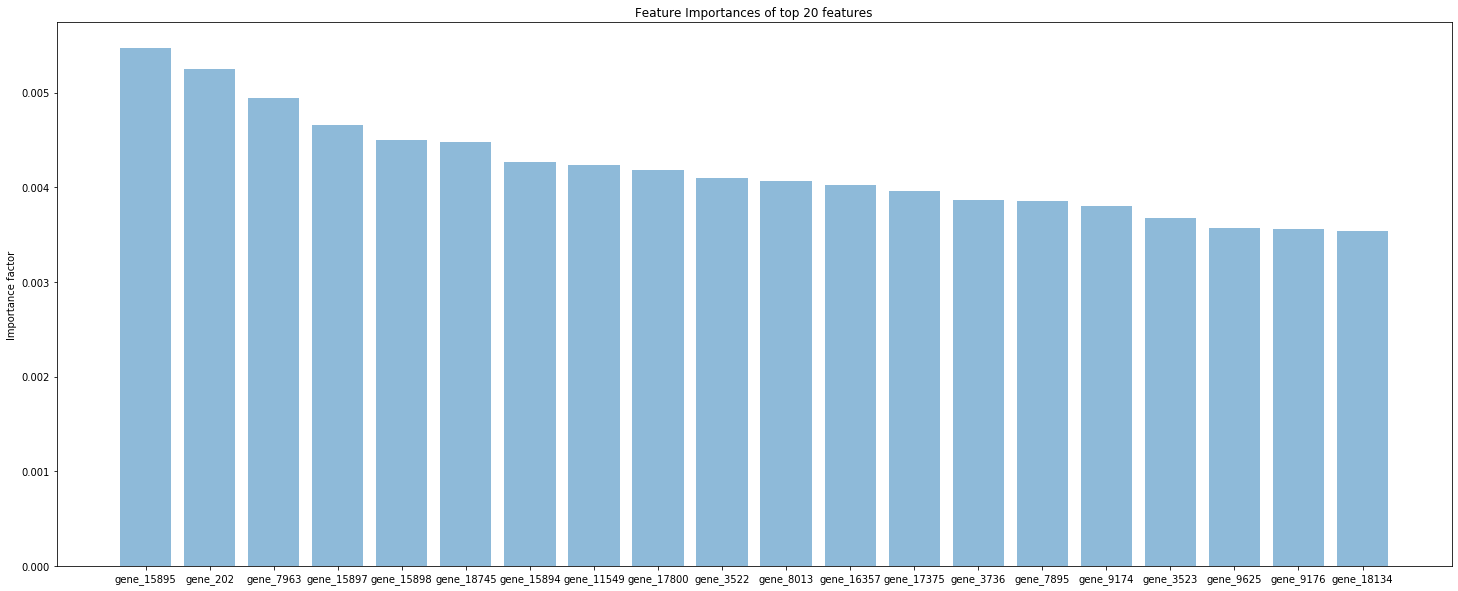

In [33]:
plt.figure(figsize=(25, 10))
plt.bar(top_features.keys(), top_features.values(), align='center', alpha=0.5)
plt.ylabel('Importance factor')
plt.title('Feature Importances of top 20 features')
plt.show()

## Correlation Heatmap of Top 20 Important Features

Text(0.5, 1, 'Correlation heatmap for the top 20 important features')

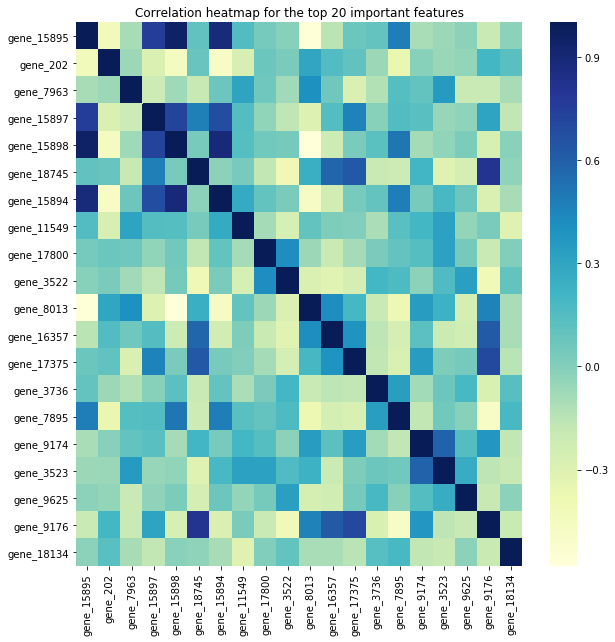

In [34]:
corr = df[top_features.keys()].corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr,cmap="YlGnBu").set_title("Correlation heatmap for the top 20 important features")


In [68]:
def plotvector(X_train, y_train, X_test, y_test):
    results = []
    max1 = 0
    max2 = 0
    
    for i in range(1, 15):
        pipe_xgb = Pipeline([('pca', PCA(n_components=i, random_state=1)),
                     ('clf', DecisionTreeClassifier())])
        
        pipe_xgb.fit(X_train, y_train)
        if(max1<pipe_xgb.score(X_test, y_test)):
            max1 = pipe_xgb.score(X_test, y_test)
            max2 = i
        results.append([i, pipe_xgb.score(X_test, y_test)])
    return np.array(results),max2





In [69]:
PCA_accuracy,max1 =  plotvector(X_train, y_train, X_test, y_test)

In [70]:
PCA_accuracy, max1

(array([[ 1.        ,  0.41078838],
        [ 2.        ,  0.82987552],
        [ 3.        ,  0.88381743],
        [ 4.        ,  0.88381743],
        [ 5.        ,  0.95020747],
        [ 6.        ,  0.95020747],
        [ 7.        ,  0.92946058],
        [ 8.        ,  0.93360996],
        [ 9.        ,  0.93775934],
        [10.        ,  0.95435685],
        [11.        ,  0.94190871],
        [12.        ,  0.94605809],
        [13.        ,  0.95020747],
        [14.        ,  0.95435685]]), 10)

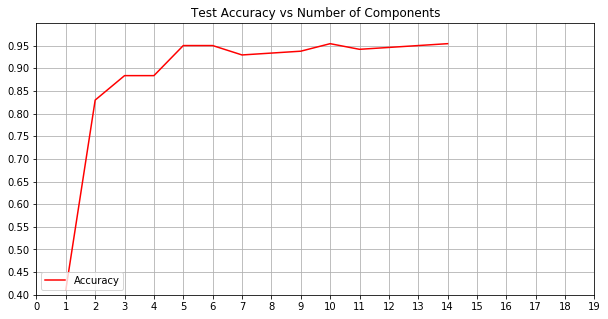

In [71]:
plt.figure(figsize=(10, 5))
plt.plot(PCA_accuracy[:,0], PCA_accuracy[:,1], color='r', label='Accuracy')
plt.legend(loc=3)
plt.ylim(0.4, 1.0)
plt.xlim(0,15)
plt.xticks(np.arange(0, 20, 1.0))
plt.yticks(np.arange(0.4, 1, 0.05))
plt.title("Test Accuracy vs Number of Components")
plt.grid(True)
plt.show()

In [39]:
pca = PCA(n_components=max1)
principal_component = pca.fit_transform(X_train)

In [40]:
principal_df = pd.DataFrame(data=principal_component)
y_train_pca = pd.DataFrame(data = labelenc.inverse_transform(y_train), columns = ["Class"])
concat_df = pd.concat([principal_df, y_train_pca], axis=1)

/Users/shashank/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


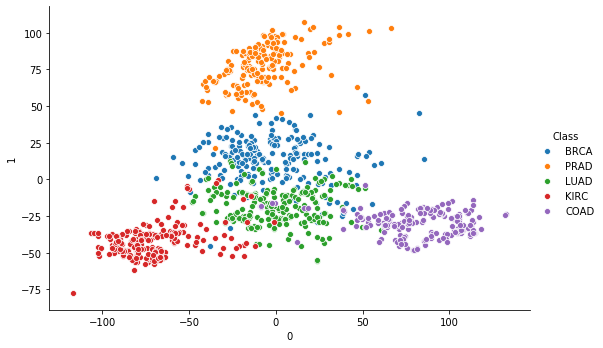

In [41]:
sns.pairplot(x_vars = 0, y_vars = 1,data=concat_df, hue="Class",size=5,aspect=1.5)
plt.show()

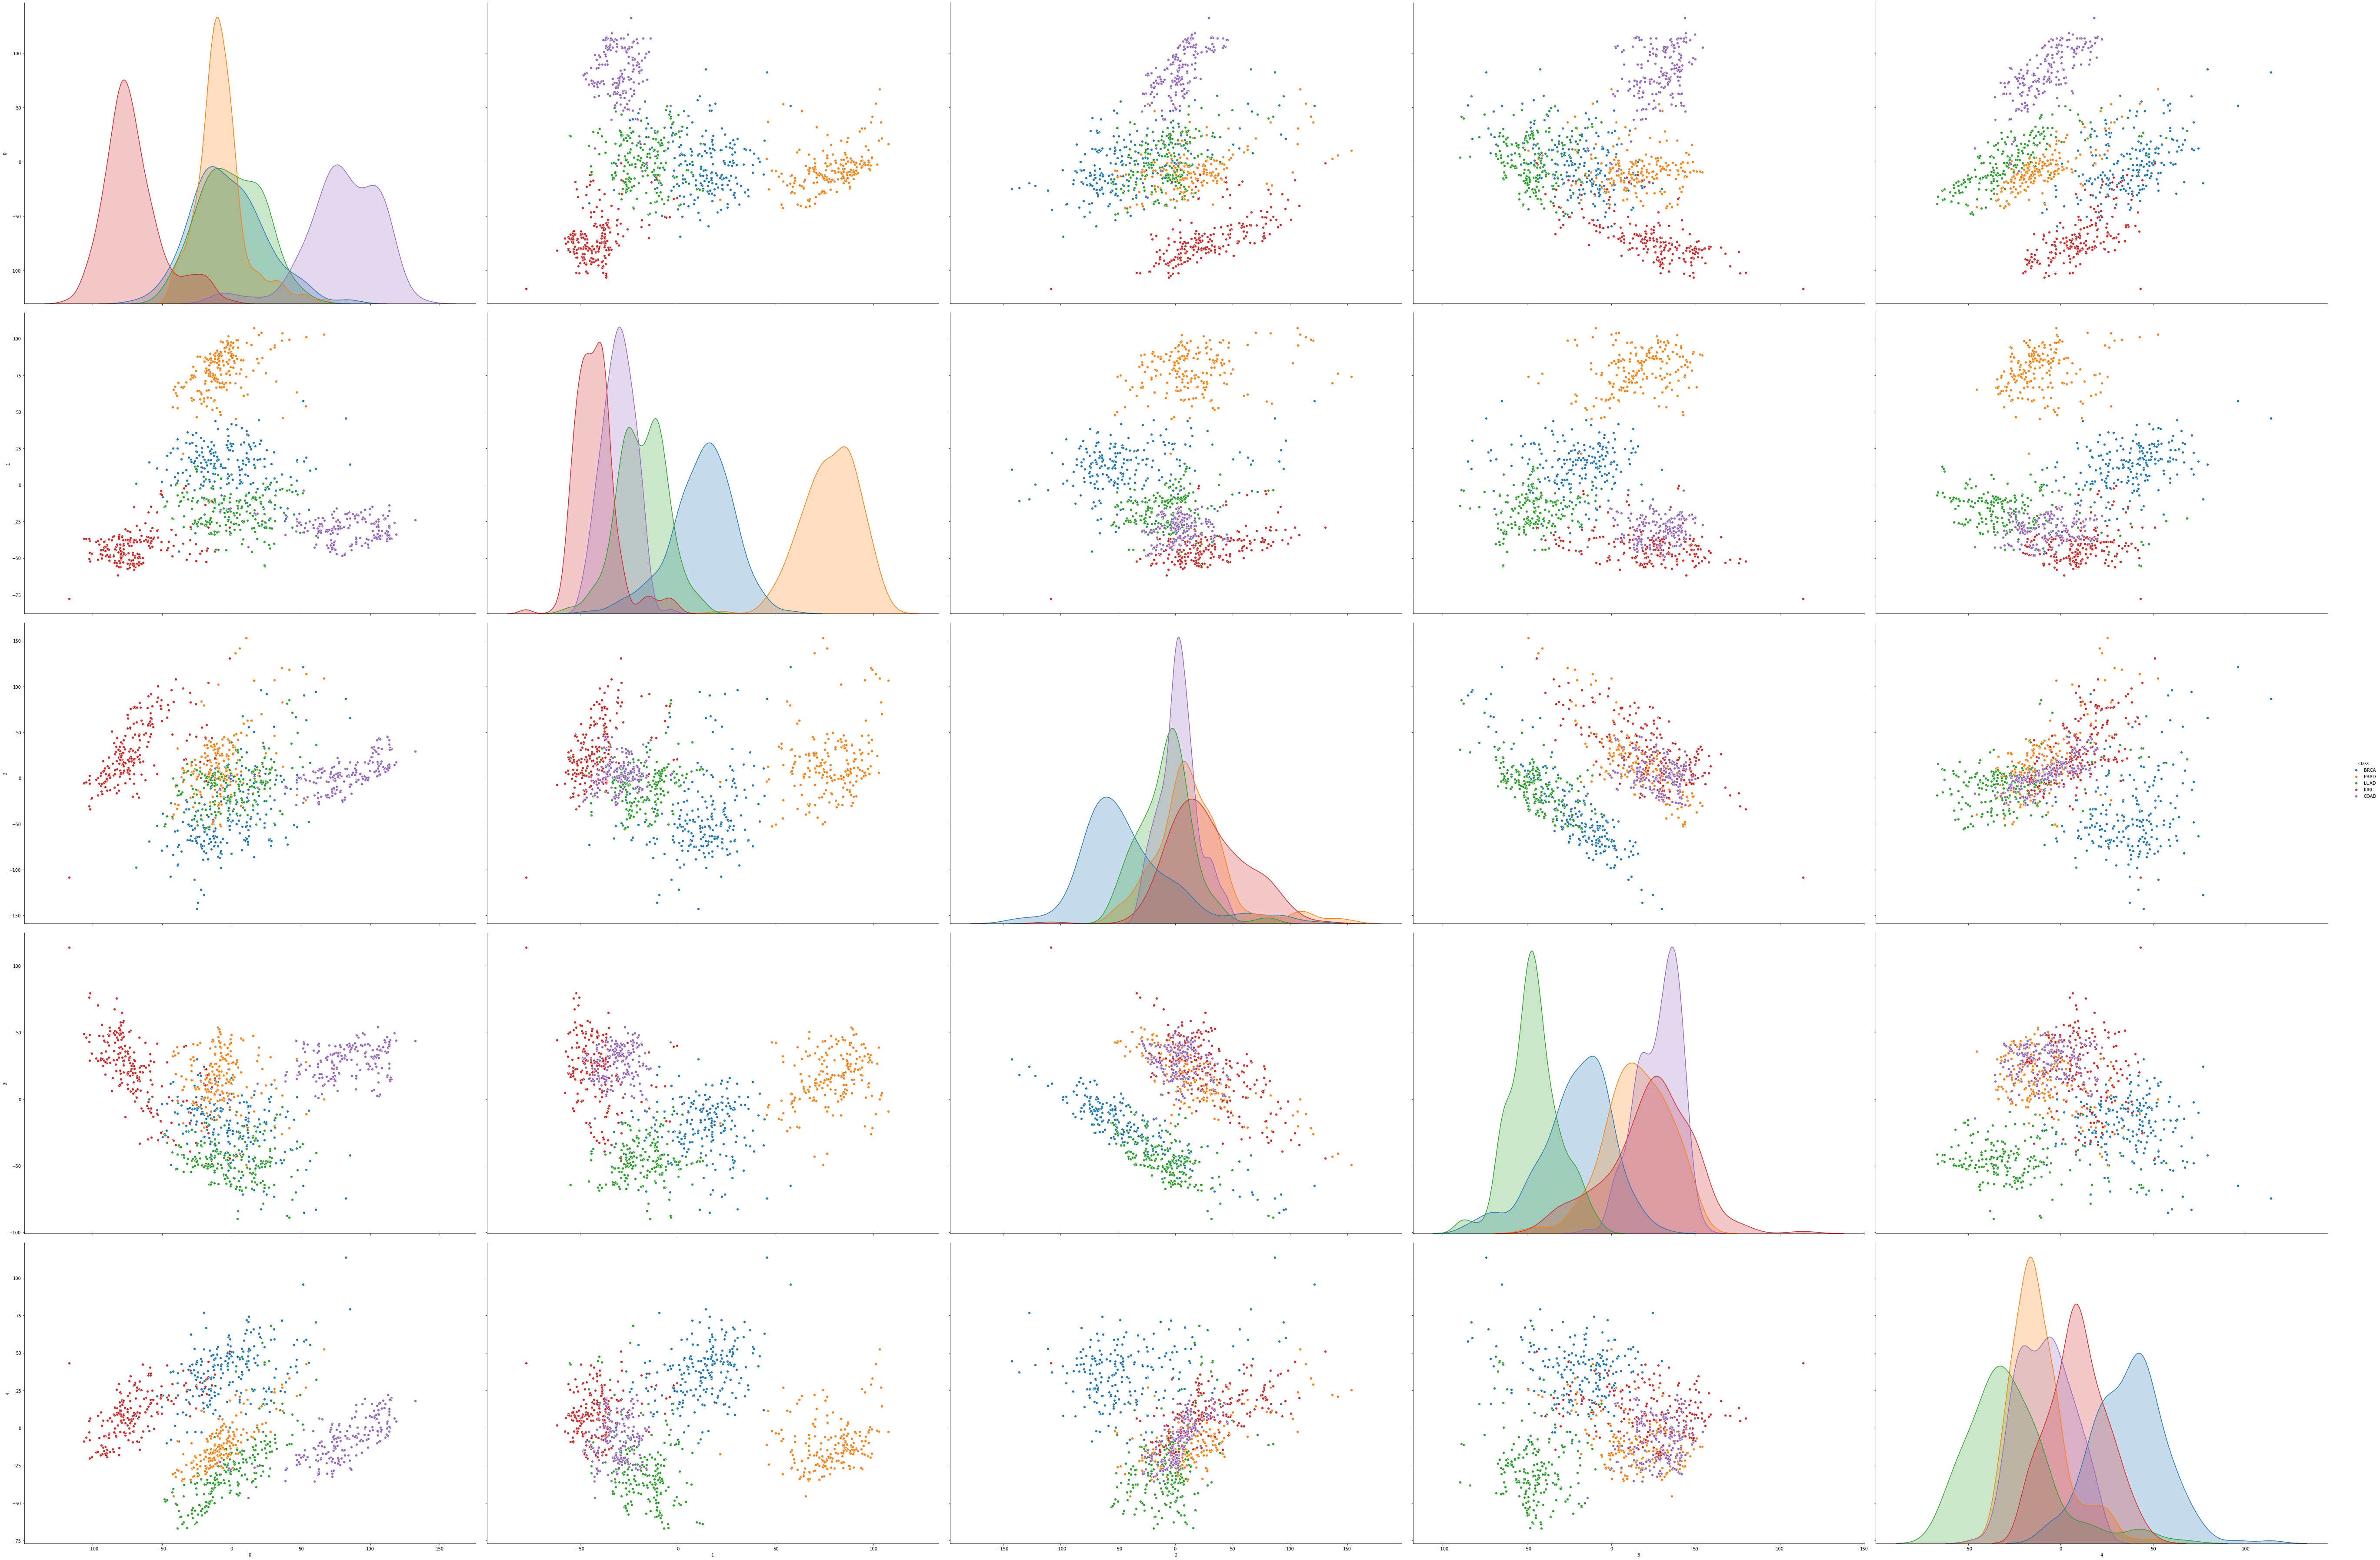

In [42]:
sns.pairplot(data=concat_df, hue="Class",size=10,aspect=1.5)
plt.show()

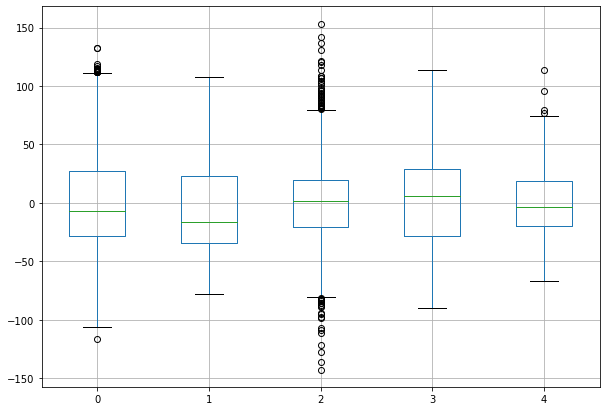

In [43]:
concat_df.boxplot(figsize= (10,7))

In [44]:
tsne = TSNE(n_components=2
            , random_state=0)
principal_component1 = tsne.fit_transform(X_train)
principal_df = pd.DataFrame(data=principal_component1)
y_train_tsne = pd.DataFrame(data = labelenc.inverse_transform(y_train), columns = ["Class"])
concat_df1 = pd.concat([principal_df, y_train_tsne], axis=1)


/Users/shashank/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


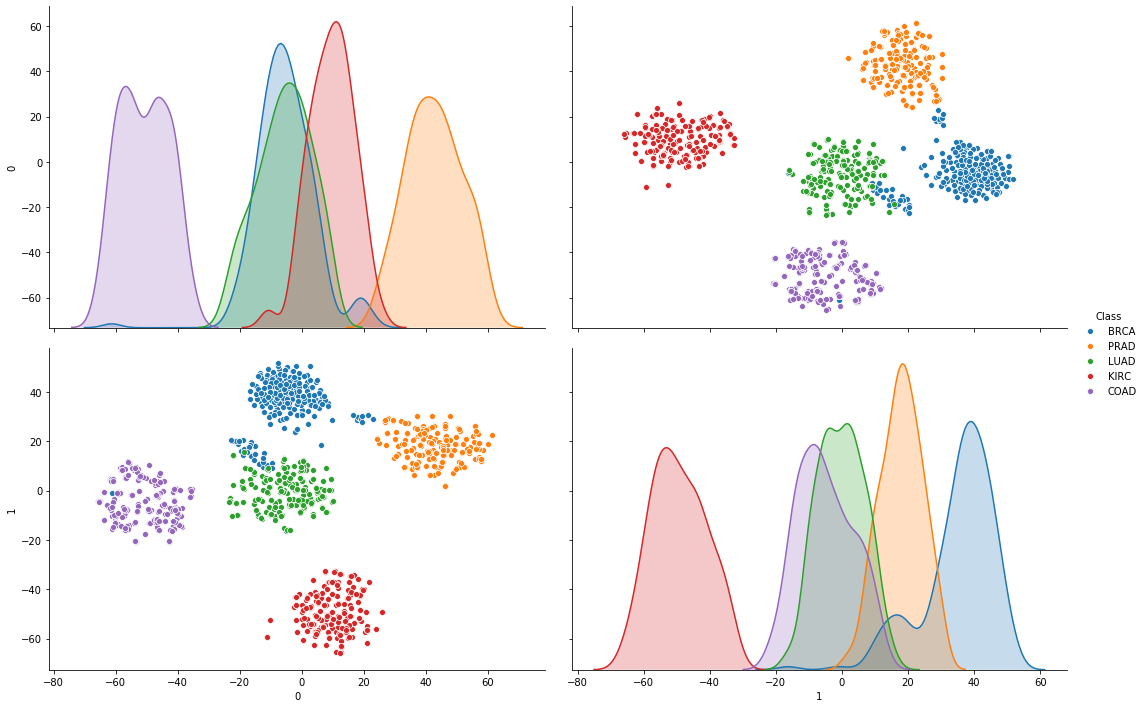

In [45]:
sns.pairplot(data=concat_df1, hue="Class",size=5,aspect=1.5)
plt.show()

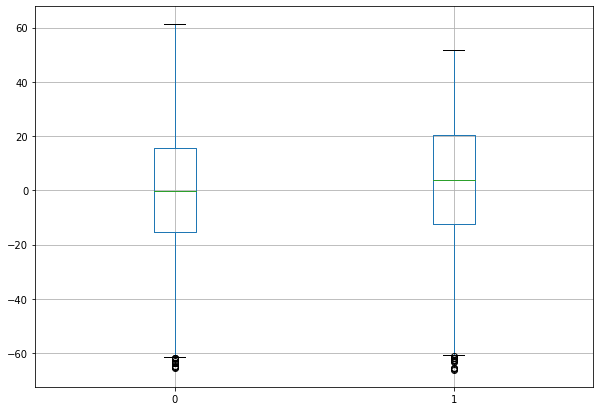

In [46]:
concat_df1.boxplot(figsize= (10,7))

In [47]:
concat_df1.head()

,0,1,Class
0,-9.902954,36.714199,BRCA
1,-6.330904,44.074284,BRCA
2,47.871288,30.391361,PRAD
3,-6.829439,28.530396,BRCA
4,33.984760,13.595883,PRAD


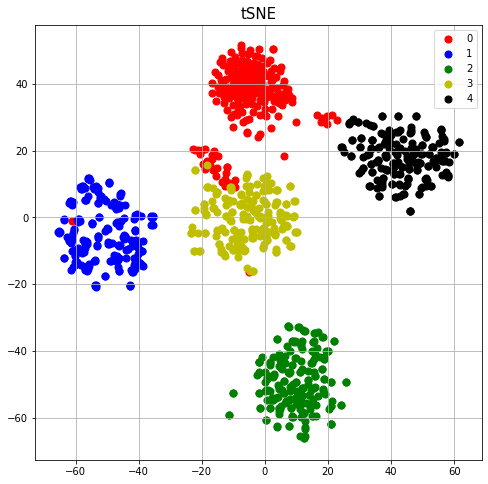

In [49]:
fig_2 = plt.figure(figsize=(8,8))
ax_2 = fig_2.add_subplot(1,1,1)
ax_2.set_title('tSNE', fontsize=15)
labels_list_2 = [0, 1, 2, 3, 4]
colors_2 = ['r', 'b', 'g', 'y', 'black']

for lab, color in zip(labels_list_2, colors_2):
    indices_2 = labelenc.transform(concat_df1['Class']) == lab
    ax_2.scatter(concat_df1.loc[indices_2, 0],
              concat_df1.loc[indices_2, 1], 
              c = color,
              s = 50)
    ax_2.legend(labels_list_2)
    ax_2.grid()

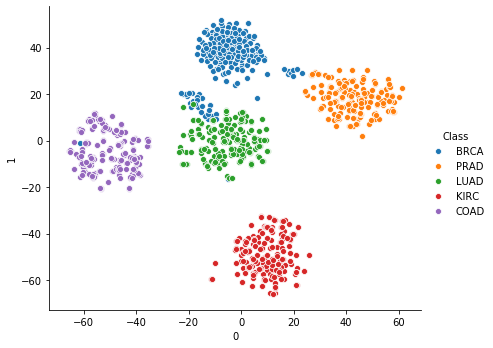

In [50]:
sns.pairplot(x_vars=0, y_vars=1, data=concat_df1, hue="Class",height=5,aspect=1.2)
plt.show()

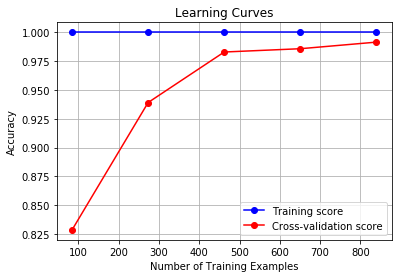

In [51]:
from sklearn.model_selection import learning_curve
classifier = DecisionTreeClassifier(criterion='entropy', presort=True, random_state=None, class_weight=None)
plt.figure()
plt.title("Learning Curves")
plt.xlabel("Number of Training Examples")
plt.ylabel("Accuracy")
plt.grid()
train_sizes, train_scores, test_scores = learning_curve(classifier, X_train, y_train, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="Cross-validation score")
plt.legend(loc="best")

In [52]:
X_train.shape

(1050, 20531)

## Model Selection

In [53]:
#Machine Learning Algorithm (MLA) Selection and Initialization

MLA = [
    ensemble.RandomForestClassifier(),
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),    
    DecisionTreeClassifier(),
    svm.LinearSVC()
    ]

MLA_predict = df.Class

### Principal Component Analysis

In [54]:
from sklearn.metrics import classification_report

#create table to compare MLA metrics
MLA_columns = ['Model Name','Train Accuracy Mean', 'Test Accuracy Mean','Time']
MLA_compare_pca = pd.DataFrame(columns = MLA_columns)



#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    
    MLA_compare_pca.loc[row_index, 'Model Name'] = MLA_name
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    pipe_alg = Pipeline([('pca', PCA(n_components=6)),
                         ('clf', alg)])
    
    cv_results = model_selection.cross_validate(pipe_alg, X_train, y_train, cv=5, n_jobs=-1, verbose=2, return_train_score=True)

    MLA_compare_pca.loc[row_index, 'Time'] = cv_results['fit_time'].mean()
    MLA_compare_pca.loc[row_index, 'Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare_pca.loc[row_index, 'Test Accuracy Mean'] = cv_results['test_score'].mean()   

    #save MLA predictions - see section 6 for usage
    pipe_alg.fit(X_train, y_train)
    MLA_predict[MLA_name] = pipe_alg.predict(X_test)
    y_true, y_pred = y_test, MLA_predict[MLA_name]
    #print(MLA_name)
    #print(classification_report(y_true,y_pred))
    MLA_compare_pca.loc[row_index, 'F1 Score'] = classification_report(y_true,y_pred, output_dict=True)['weighted avg']['f1-score']
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare_pca.sort_values(by = ['F1 Score'], ascending = False, inplace = True)
MLA_compare_pca
#MLA_predict

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished
/Users/shashank/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/shashank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.7

,Model Name,Train Accuracy Mean,Test Accuracy Mean,Time,F1 Score
0,RandomForestClassifier,0.999524,0.98381,1.50511,0.971056
2,GaussianNB,0.972381,0.972381,1.45087,0.955007
3,DecisionTreeClassifier,1,0.969524,1.44254,0.938157
1,BernoulliNB,0.93381,0.927619,1.42563,0.874988
4,LinearSVC,0.94,0.93619,1.44853,0.857289


### TSNE

In [55]:
size_train = X_train.shape[0]
X = np.vstack((X_train,X_test))
X_tsne = TSNE(n_components=2, random_state=0).fit_transform( X ) 
X_train_tsne = X_tsne[0:size_train,:]
X_test_tsne  = X_tsne[size_train:,:]

In [56]:
X_train_tsne.shape

(1050, 2)

In [57]:
from sklearn.metrics import classification_report

#create table to compare MLA metrics
MLA_columns = ['Model Name','Train Accuracy Mean', 'Test Accuracy Mean','Time']
MLA_compare_tsne = pd.DataFrame(columns = MLA_columns)



#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    
    MLA_compare_tsne.loc[row_index, 'Model Name'] = MLA_name
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    
    cv_results = model_selection.cross_validate(alg, X_train_tsne, y_train, cv=5, n_jobs=-1, verbose=2, return_train_score=True)

    MLA_compare_tsne.loc[row_index, 'Time'] = cv_results['fit_time'].mean()
    MLA_compare_tsne.loc[row_index, 'Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare_tsne.loc[row_index, 'Test Accuracy Mean'] = cv_results['test_score'].mean()   

    #save MLA predictions - see section 6 for usage
    alg.fit(X_train_tsne, y_train)
    MLA_predict[MLA_name] = alg.predict(X_test_tsne)
    y_true, y_pred = y_test, MLA_predict[MLA_name]
    #print(MLA_name)
    #print(classification_report(y_true,y_pred))
    MLA_compare_tsne.loc[row_index, 'F1 Score'] = classification_report(y_true,y_pred, output_dict=True)['weighted avg']['f1-score']
    row_index+=1
    

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare_tsne.sort_values(by = ['F1 Score'], ascending = False, inplace = True)
MLA_compare_tsne
#MLA_predict


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
/Users/shashank/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | 

,Model Name,Train Accuracy Mean,Test Accuracy Mean,Time,F1 Score
4,LinearSVC,0.961905,0.959048,0.0399505,0.995840
0,RandomForestClassifier,0.999048,0.993333,0.0106678,0.991704
2,GaussianNB,0.989286,0.989524,0.000882578,0.987583
3,DecisionTreeClassifier,1,0.991429,0.000746822,0.987521
1,BernoulliNB,0.719048,0.719048,0.000780344,0.776218


## Hyperparameter Tuning on Random Forest Classifier

In [74]:
parameters = {'criterion':('entropy', 'gini'), 'n_estimators':[250, 500, 1000, 1500]}
rf = ensemble.RandomForestClassifier(bootstrap=True, oob_score=True, random_state=0)
clf = GridSearchCV(rf, parameters, cv=5)
clf.fit(X_train_tsne, y_train)
clf.cv_results_

{'mean_fit_time': array([0.21552444, 0.41593142, 0.85190749, 1.26121244, 0.19063277,
        0.38236523, 0.78803596, 1.20297108]),
 'std_fit_time': array([0.00896275, 0.01011449, 0.01653721, 0.01966497, 0.00350392,
        0.00787961, 0.02612023, 0.02056801]),
 'mean_score_time': array([0.01436186, 0.0290226 , 0.05878806, 0.1021534 , 0.01433306,
        0.02968841, 0.05870481, 0.09078279]),
 'std_score_time': array([0.00051166, 0.00100951, 0.00411643, 0.03321533, 0.00044695,
        0.00215077, 0.00216698, 0.00291768]),
 'param_criterion': masked_array(data=['entropy', 'entropy', 'entropy', 'entropy', 'gini',
                    'gini', 'gini', 'gini'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[250, 500, 1000, 1500, 250, 500, 1000, 1500],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=ob

In [75]:
clf.best_params_

{'criterion': 'entropy', 'n_estimators': 250}

In [76]:
clf.best_score_

0.9942857142857143

In [77]:
clf.score(X_test_tsne, y_test)

0.995850622406639

In [78]:
print(classification_report(y_test, clf.predict(X_test_tsne)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        90
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        38
           3       1.00      0.98      0.99        47
           4       1.00      1.00      1.00        41

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241



## Hyperparameter tuning of SVM

In [79]:
parameters = {
    'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 
    'C':[1, 5, 10],
}
svc = svm.SVC(random_state=0)
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(X_train_tsne, y_train)
clf.cv_results_

/Users/shashank/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/shashank/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/shashank/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/shashank/anaconda3/lib/python3.7/site-p

{'mean_fit_time': array([2.27265358e-03, 2.46339982e+01, 2.58779526e-02, 4.60915565e-03,
        3.35617065e-03, 5.21846506e+01, 2.55677700e-02, 4.45580482e-03,
        5.40490150e-03, 5.09125830e+01, 2.54750729e-02, 4.49619293e-03]),
 'std_fit_time': array([6.11813597e-04, 1.32081777e+01, 3.74766250e-04, 2.47271466e-04,
        1.21906871e-03, 4.69613913e+01, 2.01565277e-04, 2.18671251e-04,
        1.96121859e-03, 5.21776822e+01, 4.51837299e-04, 2.30603281e-04]),
 'mean_score_time': array([0.00053692, 0.00046573, 0.0024622 , 0.00203824, 0.00033646,
        0.00047746, 0.00218496, 0.00196676, 0.00034156, 0.00047641,
        0.00220499, 0.00200334]),
 'std_score_time': array([9.82336626e-05, 1.61122986e-05, 2.34802451e-04, 8.52536300e-05,
        4.59428086e-05, 2.34022622e-05, 3.02743157e-05, 5.99665906e-05,
        5.69964235e-05, 2.73466838e-05, 3.19511498e-05, 7.29681765e-05]),
 'param_C': masked_array(data=[1, 1, 1, 1, 5, 5, 5, 5, 10, 10, 10, 10],
              mask=[False, False, 

In [80]:
clf.best_params_

{'C': 1, 'kernel': 'linear'}

In [81]:
clf.best_score_

0.9895238095238095

In [82]:
clf.score(X_test_tsne, y_test)

0.995850622406639

In [83]:
print(classification_report(y_test, clf.predict(X_test_tsne)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        90
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        38
           3       1.00      0.98      0.99        47
           4       1.00      1.00      1.00        41

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241



## Hyperparameter Tuning of Decision Trees

In [84]:
parameters ={'max_depth':[11, 15, 20, 25],'criterion':['gini','entropy']}
dt = DecisionTreeClassifier(random_state=1)
clf = GridSearchCV(dt, parameters, cv=10)
clf.fit(X_train_tsne, y_train)
clf.cv_results_

{'mean_fit_time': array([0.00109336, 0.00108247, 0.00084982, 0.00085332, 0.00125771,
        0.00117707, 0.00108097, 0.00104451]),
 'std_fit_time': array([1.15826703e-04, 1.36006705e-04, 1.74981046e-05, 1.17530419e-04,
        2.05652238e-04, 1.21482443e-04, 1.25219038e-04, 4.33024852e-05]),
 'mean_score_time': array([0.00031829, 0.0003243 , 0.0002224 , 0.00020683, 0.00028014,
        0.00024366, 0.00019808, 0.00019457]),
 'std_score_time': array([6.74374021e-05, 9.06221963e-05, 2.70742747e-05, 2.67342081e-05,
        9.44511383e-05, 5.42989612e-05, 3.06088602e-05, 2.61456058e-05]),
 'param_criterion': masked_array(data=['gini', 'gini', 'gini', 'gini', 'entropy', 'entropy',
                    'entropy', 'entropy'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[11, 15, 20, 25, 11, 15, 20, 25],
              mask=[False, False, False, False, False, False, False, Fals

In [85]:
clf.best_params_

{'criterion': 'entropy', 'max_depth': 11}

In [86]:
clf.best_score_

0.9933333333333333

In [87]:
clf.score(X_test_tsne, y_test)

0.991701244813278

In [88]:
print(classification_report(y_test, clf.predict(X_test_tsne)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        90
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        38
           3       1.00      0.96      0.98        47
           4       1.00      1.00      1.00        41

    accuracy                           0.99       241
   macro avg       1.00      0.99      0.99       241
weighted avg       0.99      0.99      0.99       241

